In [1]:
# MATPLOTLIB INTERACTIVE VISUALIZATION. REMOVE (OR COMMENT) IF YOU NEED TO PRINT THE NOTEBOOK AS A PDF, SOMETIMES IT DOES NOT WORK WELL...
#%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# pd.options.display.max_rows = 9999
pd.options.display.max_columns = 200

#set initial random state
rs = 328537
np.random.seed(rs)

In [2]:
DATASETPATH = "./data/DSL_Winter_Project_2024/DSL_Winter_Project_2024/development.csv"
dataset = pd.read_csv(DATASETPATH)

In [3]:
def generateColumnsNames(title, ignore=[]):
    out = []
    for i in range(0, 18):
        if(not i in ignore):
            out.append( title + "[" + str(i) + "]" )
    return out

In [4]:
def generateColumnsNamesFromIndexes(indexes):
    out = []
    for index in indexes:
        for label in ["pmax", "negpmax", "area", "tmax", "rms"]:
            out.append(label + "[" + str(index) + "]")
    return out

regressionTargets = ['x', 'y']
noisyIndexes = [0, 7, 12, 15, 16, 17]

#noisyFeatures= generateColumnsNamesFromIndexes(noisyIndexes)
#featuresLabels = dataset.columns.drop(np.hstack([regressionTargets, noisyFeatures]))

featuresLabels = generateColumnsNames("area", ignore=noisyIndexes) + generateColumnsNames("pmax", ignore=noisyIndexes) + generateColumnsNames("negpmax", ignore=noisyIndexes)
dataset_shuff = dataset.sample(random_state=rs, frac=1)  #shuffle the dataset
X_df = dataset_shuff[featuresLabels]
Y_df = dataset_shuff[regressionTargets]

In [5]:
stdScaler=StandardScaler()
X_std = stdScaler.fit_transform(X_df.values)

In [6]:
def euc_dist(Y, Y_pred):
    #return np.sqrt(((Y_pred - Y_test)**2).sum(axis=1)).sum(axis=0) / Y_pred.shape[0]
    return np.sqrt(((Y - Y_pred)**2).sum(axis=1)).mean()

euc_dist_scorer = make_scorer(euc_dist, greater_is_better=False)

In [7]:
reg = KNeighborsRegressor()
params = {
    "weights": ["uniform", "distance"],
    "n_neighbors" : [40, 50, 60]
}
grid_search = GridSearchCV(reg, param_grid=params, scoring=euc_dist_scorer, verbose=3, n_jobs=1)
grid_search.fit(X_std, Y_df.values)



Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..n_neighbors=40, weights=uniform;, score=-6.440 total time= 3.4min
[CV 2/5] END ..n_neighbors=40, weights=uniform;, score=-6.466 total time= 3.3min
[CV 3/5] END ..n_neighbors=40, weights=uniform;, score=-6.401 total time= 3.5min
[CV 4/5] END ..n_neighbors=40, weights=uniform;, score=-6.460 total time= 3.5min
[CV 5/5] END ..n_neighbors=40, weights=uniform;, score=-6.467 total time= 3.4min
[CV 1/5] END .n_neighbors=40, weights=distance;, score=-6.404 total time= 3.3min
[CV 2/5] END .n_neighbors=40, weights=distance;, score=-6.434 total time= 2.7min
[CV 3/5] END .n_neighbors=40, weights=distance;, score=-6.362 total time= 3.1min
[CV 4/5] END .n_neighbors=40, weights=distance;, score=-6.421 total time= 3.2min
[CV 5/5] END .n_neighbors=40, weights=distance;, score=-6.430 total time= 3.1min
[CV 1/5] END ..n_neighbors=50, weights=uniform;, score=-6.488 total time= 3.1min
[CV 2/5] END ..n_neighbors=50, weights=uniform;, 

GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=1,
             param_grid={'n_neighbors': [40, 50, 60],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(euc_dist, greater_is_better=False), verbose=3)

In [8]:
grid_search.best_params_

{'n_neighbors': 40, 'weights': 'distance'}

In [24]:
-grid_search.best_score_

6.410147437244996

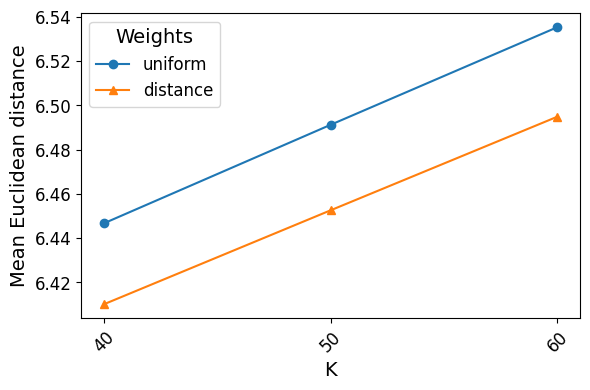

In [25]:
def unique(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

k = grid_search.cv_results_["param_n_neighbors"].reshape(-1, len(weights))
weights = unique(grid_search.cv_results_["param_weights"])
scores = -grid_search.cv_results_["mean_test_score"].reshape(-1, len(weights))
plt.figure(figsize=(6,4))
for i, marker in zip(range(scores.shape[0]), ['o', '^']):
    plt.plot(scores[:, i], marker=marker)
plt.xticks(range(0, scores.shape[0]), k[:, 0], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("K", fontsize=14)
plt.ylabel("Mean Euclidean distance", fontsize=14)
legend = plt.legend(weights, title="Weights", fontsize=12)
plt.setp(legend.get_title(),fontsize=14)
plt.tight_layout()
plt.savefig("KNN_grid_search_results1", format="pdf")

Text(0, 0.5, 'Mean Euclidean distance')

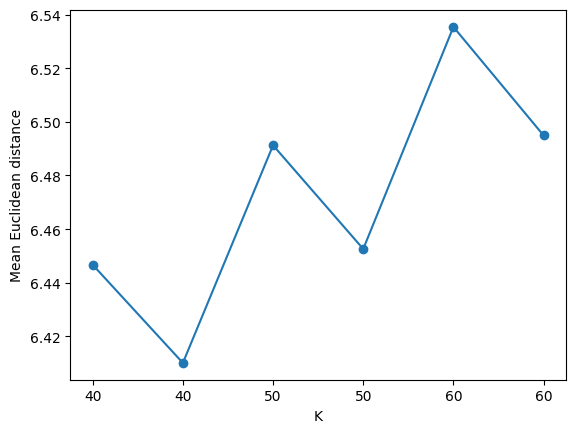

In [10]:
scores = -grid_search.cv_results_["mean_test_score"]
k = grid_search.cv_results_["param_n_neighbors"]
plt.figure()
plt.plot(scores, '-o')
plt.xticks(range(0, len(k)), k)
plt.xlabel("K")
plt.ylabel("Mean Euclidean distance")


In [11]:
EVALUATIONPATH = "./data/DSL_Winter_Project_2024/DSL_Winter_Project_2024/evaluation.csv"
evaluation = pd.read_csv(EVALUATIONPATH, index_col="Id")
#X_ev = X_ev[generateColumnsNames("area", ignore=noisyIndexes) + generateColumnsNames("pmax", ignore=noisyIndexes)]
X_ev = evaluation[featuresLabels]

X_ev_std = stdScaler.transform(X_ev.values)

Y_ev = grid_search.predict(X_ev_std)


In [12]:
output = pd.DataFrame()
Y_ev_df = pd.DataFrame(Y_ev)
display(Y_ev_df)
#output['Predicted'] = (Y_ev_df[0]).round().astype(str) + "|" + (Y_ev_df[1]).round().astype(str)
output['Predicted'] = (Y_ev_df[0]).astype(str) + "|" + (Y_ev_df[1]).astype(str)
output.to_csv("submission14_KK1.csv", index_label="Id")

,0,1
0,471.033351,343.060992
1,525.000827,558.953010
2,207.190654,394.857043
3,583.066303,507.391542
4,368.195030,356.728145
...,...,...
128495,444.959485,264.719396
128496,276.440911,230.109030
128497,454.157754,589.503225
128498,232.239085,385.009803
